In [1]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
BATCH_SIZE = 2

IMG_SIZE = 515

NUM_CLASSES = 5

NUM_TRAIN_IMAGES = 7470

NUM_VAL_IMAGES = 1602

NUM_TEST_IMAGES = 1602

# Load data

In [3]:
abs_path = %pwd

In [4]:
slash_idx = [idx for idx,ch in enumerate(abs_path) if ch=='/']

abs_path = abs_path[:slash_idx[-2]]

In [5]:
DATA_DIR = abs_path + '/data/processed'

DATA_DIR

'/home/marcin/git_workspace/roads_semantic_segmentation_in_LandCover.ai_dataset/data/processed'

In [6]:
TRAIN_PATH = DATA_DIR + '/train'
VAL_PATH = DATA_DIR + '/val'
TEST_PATH = DATA_DIR + '/test'

In [7]:
train_images = sorted(glob(os.path.join(TRAIN_PATH, "images/img/*")))
train_masks = sorted(glob(os.path.join(TRAIN_PATH, "masks/img/*")))
val_images = sorted(glob(os.path.join(VAL_PATH, "images/img/*")))
val_masks = sorted(glob(os.path.join(VAL_PATH, "masks/img/*")))


def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=3)
        image = image[..., 0]
        image = tf.reshape(image, (512, 512, 1))
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[512, 512])
    else:
        image = tf.image.decode_jpeg(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMG_SIZE, IMG_SIZE])
        image = image / 127.5 - 1
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)


Train Dataset: <BatchDataset shapes: ((2, 515, 515, 3), (2, 512, 512, 1)), types: (tf.float32, tf.float32)>
Val Dataset: <BatchDataset shapes: ((2, 515, 515, 3), (2, 512, 512, 1)), types: (tf.float32, tf.float32)>


# Build DeepLabv3+ and load weights

https://keras.io/examples/vision/deeplabv3_plus/

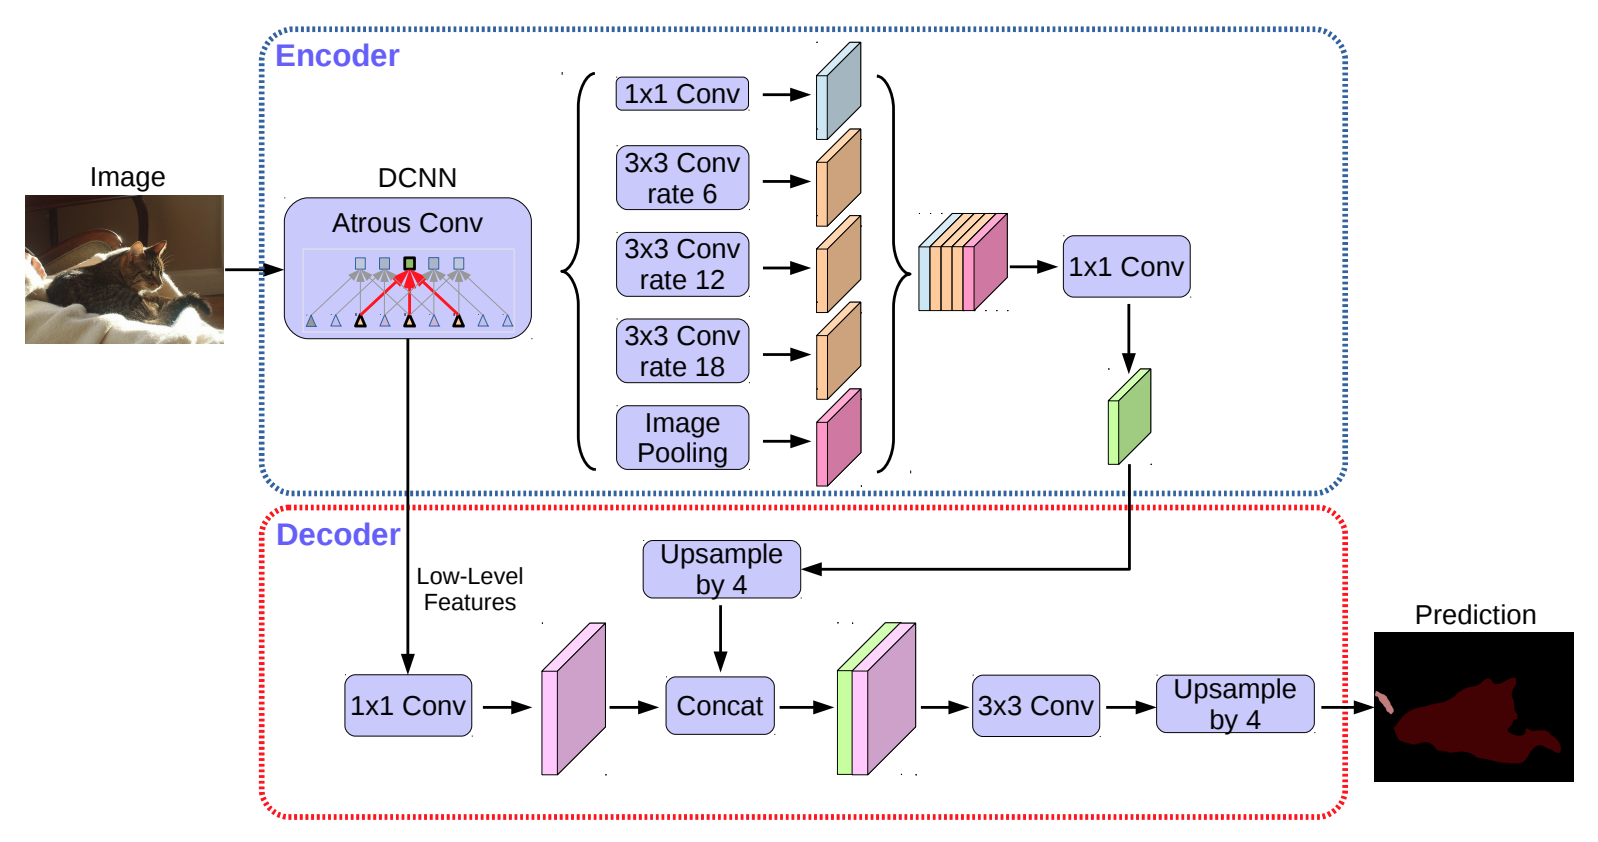

In [8]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=tf.keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output


In [9]:
# xception = tf.keras.applications.Xception(include_top=False, weights='imagenet', input_shape=(515,515,3))

# xception.trainable = False

In [10]:
# xception.summary()

In [11]:
# resnet50 = tf.keras.applications.ResNet50(
#         weights="imagenet", include_top=False, input_shape=(512, 512, 3))

# resnet50.summary()

In [12]:
def DeeplabV3Plus(img_size, num_classes):
    model_input = tf.keras.Input(shape=(img_size, img_size, 3))
    
#     resnet50 = tf.keras.applications.ResNet50(
#         weights="imagenet", include_top=False, input_tensor=model_input
#     )
    
#     x = resnet50.get_layer("conv4_block6_2_relu").output

    xception = tf.keras.applications.Xception(
        include_top=False, weights='imagenet', input_tensor=model_input)
    
    xception.trainable = False
    
    x = xception.get_layer('block13_sepconv2_bn').output
    
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(img_size // 4 // x.shape[1], img_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
#     input_b = resnext50.get_layer("conv2_block3_2_relu").output
    input_b = xception.get_layer("block3_sepconv2_act").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(img_size // x.shape[1], img_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return tf.keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(img_size=IMG_SIZE, num_classes=NUM_CLASSES)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 515, 515, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 257, 257, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 257, 257, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 257, 257, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [13]:
# callbacks

def get_best_weights_callback(filepath):
    
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath, 
        monitor='val_accuracy', 
        verbose=1, 
        save_best_only=True,
        save_weights_only=True, 
        mode='max', 
        save_freq='epoch')

    return checkpoint_callback

In [14]:
checkpoint_path = abs_path + '/notebooks/exploratory/results/baseline_model_DeepLabv3+/best_weights'

if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

In [15]:
early_stopping_val_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

best_val_acc = get_best_weights_callback(checkpoint_path)

Epoch 1/15
3735/3735 [==============================] - 508s 134ms/step - loss: 0.4784 - accuracy: 0.8293 - val_loss: 0.8920 - val_accuracy: 0.7465

Epoch 00001: val_accuracy improved from -inf to 0.74653, saving model to /home/marcin/git_workspace/roads_semantic_segmentation_in_LandCover.ai_dataset/notebooks/exploratory/results/baseline_model_DeepLabv3+/best_weights
Epoch 2/15
3735/3735 [==============================] - 518s 139ms/step - loss: 0.2983 - accuracy: 0.8957 - val_loss: 0.7492 - val_accuracy: 0.7426

Epoch 00002: val_accuracy did not improve from 0.74653
Epoch 3/15
3735/3735 [==============================] - 502s 135ms/step - loss: 0.2403 - accuracy: 0.9149 - val_loss: 0.6734 - val_accuracy: 0.7630

Epoch 00003: val_accuracy improved from 0.74653 to 0.76296, saving model to /home/marcin/git_workspace/roads_semantic_segmentation_in_LandCover.ai_dataset/notebooks/exploratory/results/baseline_model_DeepLabv3+/best_weights
Epoch 4/15
3735/3735 [==============================]

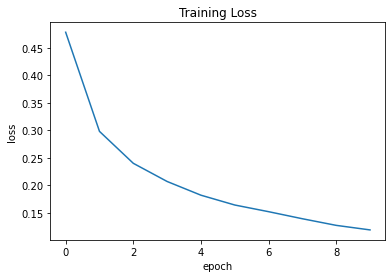

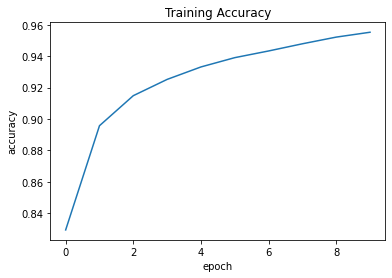

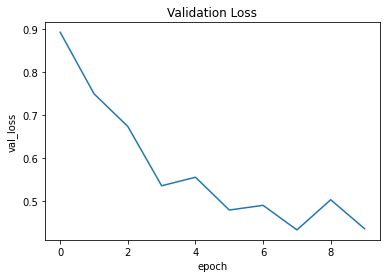

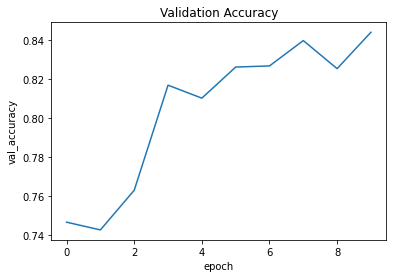

In [16]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
)

history = model.fit(train_dataset, 
                    validation_data=val_dataset, 
                    epochs=15,
                   callbacks=[early_stopping_val_loss,
                             best_val_acc])

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()


In [17]:
model.load_weights(checkpoint_path)

In [43]:
import tensorflow_addons as tfa

In [71]:
def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions


def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l][0]
        g[idx] = colormap[l][1]
        b[idx] = colormap[l][2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb


def get_overlay(image, colored_mask):
    image = tf.keras.preprocessing.image.array_to_img(image)
    image = np.array(image).astype(np.uint8)
    image = tf.image.resize(image, [512, 512])
    image.set_shape([None, None, 3])
    image = tf.reshape(image, (512,512,3))
    overlay = tfa.image.blend(image, colored_mask, 0.5)
#     overlay = cv2.addWeighted(image, 0.35, colored_mask, 0.65, 0)
    return overlay


def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            axes[i].imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else:
            axes[i].imshow(display_list[i])
    plt.show()


def plot_predictions(images_list, masks_list, colormap, model):
    for image_file, mask_file in zip(images_list, masks_list):
        image_tensor = read_image(image_file)
        mask_tensor = read_image(mask_file, mask=True)
        mask_tensor = mask_tensor[..., 0]
        mask_tensor = decode_segmentation_masks(mask_tensor, colormap, NUM_CLASSES)

        prediction_mask = infer(image_tensor=image_tensor, model=model)
        prediction_colormap = decode_segmentation_masks(prediction_mask, colormap, NUM_CLASSES)
        overlay = get_overlay(image_tensor, prediction_colormap)
        overlay_orginal = get_overlay(image_tensor, mask_tensor)
        plot_samples_matplotlib(
            [image_tensor, overlay_orginal, overlay, prediction_colormap], figsize=(18, 14)
        )


In [19]:
colormap = [[0, 0, 0], [255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 255]]

In [21]:
test_images = sorted(glob(os.path.join(TEST_PATH, "images/img/*")))
test_masks = sorted(glob(os.path.join(TEST_PATH, "masks/img/*")))
test_dataset = data_generator(test_images, val_images)

print("Test Dataset:", test_dataset)

Test Dataset: <BatchDataset shapes: ((2, 515, 515, 3), (2, 512, 512, 1)), types: (tf.float32, tf.float32)>


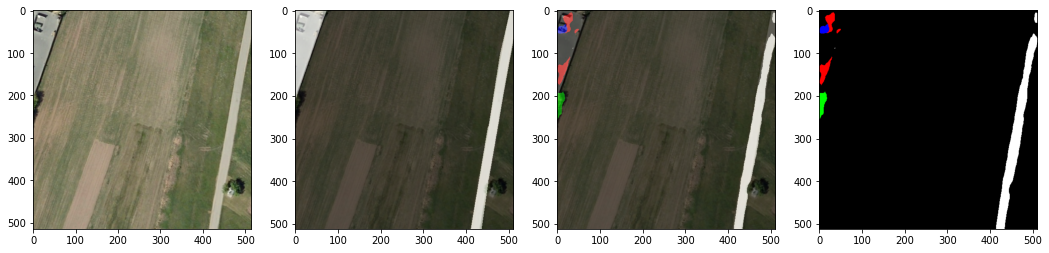

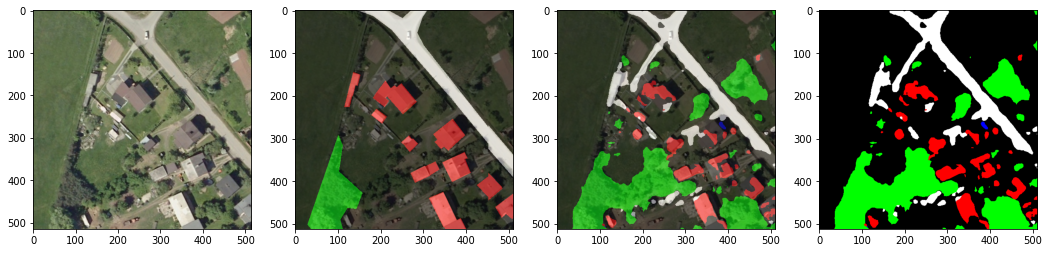

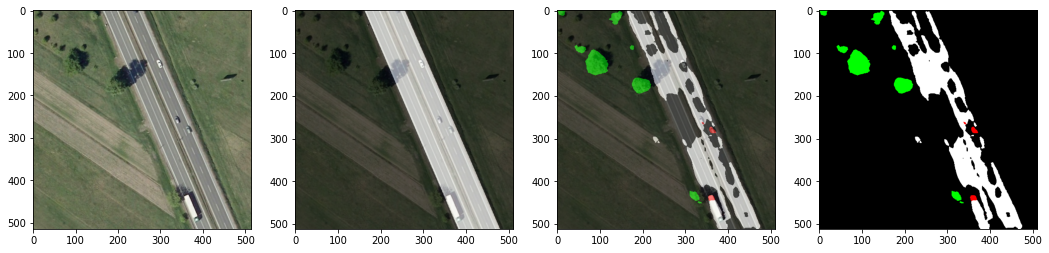

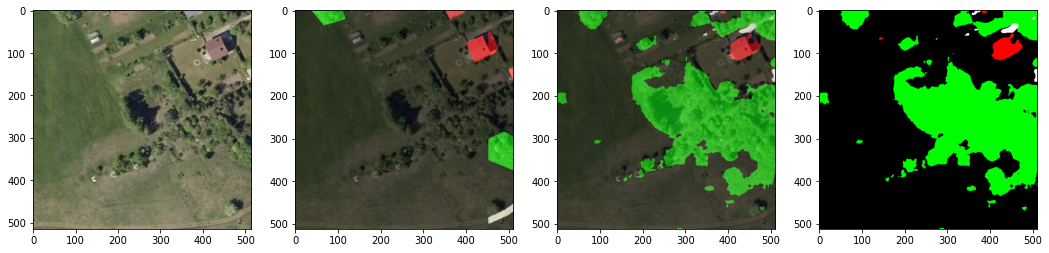

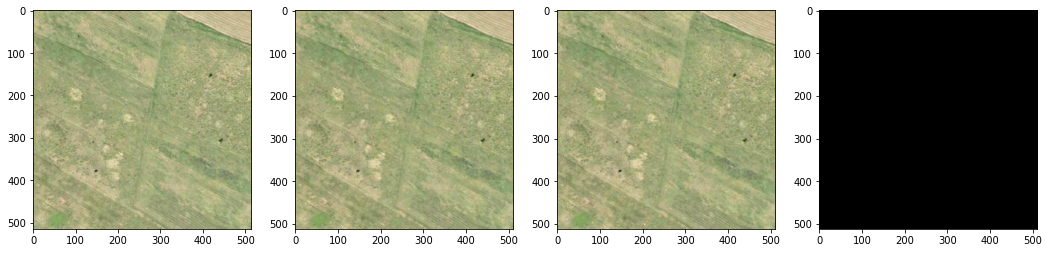

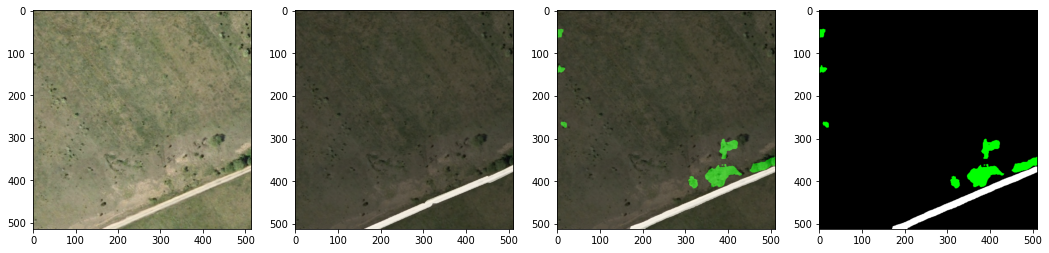

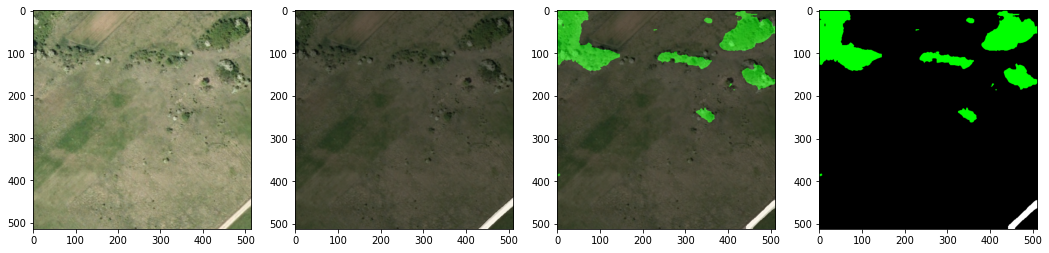

In [73]:
left_range = 448
right_range = 455

plot_predictions(test_images[left_range:right_range], test_masks[left_range:right_range] , colormap, model=model)

## mIOU metrics

In [77]:
miou = tf.keras.metrics.MeanIoU(NUM_CLASSES)

In [92]:
miou.update_state([1, 1, 0], [0, 1, 1])
miou.result().numpy()

0.2556391

In [84]:
miou.reset_state()

In [85]:
miou.result().numpy()

0.0

In [101]:
def get_miou_for_images(images_list, masks_list):
    
    m = tf.keras.metrics.MeanIoU(NUM_CLASSES)
    
    for image_file, mask_file in zip(images_list, masks_list):
        
        image_tensor = read_image(image_file)
        
        mask_tensor = read_image(mask_file, mask=True)
        mask_tensor = mask_tensor[..., 0]

        prediction_mask = infer(image_tensor=image_tensor, model=model)
        
        m.update_state([mask_tensor], [prediction_mask])
        
    return m.result().numpy()

In [103]:
get_miou_for_images(test_images, test_masks)

0.5878613